In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # TrueType fonts to be ICPR compatible
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
PATH="./results/"
PATTERN="hourly-{method}-{features}-{dates}-seed{seed}-bias.res"
PATTERN_ENSEMBLE="hourly-{method}-{features}-{dates}-ensemble{nmodels}-seed{seed}-bias.res"
def load_data(method='LIMES', features='tweet', dates='0_5', seeds=range(10)):
    DATA=[]
    for seed in seeds:
        if method.startswith('ensemble') and method != 'ensemble':
            nmodels = int(method[5:])
            filename = PATH+PATTERN_ENSEMBLE.format(method='ensemble', nmodels=nmodels, features=features, dates=dates, seed=seed)
        else:
            filename = PATH+PATTERN.format(method=method, features=features, dates=dates, seed=seed)
        data = np.loadtxt(filename, usecols=[1])
        DATA.append(data)
    return np.vstack(DATA)

In [3]:
RES,AVG_ACC,MIN_ACC = {},{},{}
for feats in ['tweet','location','tweet_location']:
    for dates in ['0_5' ,'10_15']:
        for method in ['LIMES','incremental','restart','ensemble']:
            res = load_data(method=method,features=feats,dates=dates)
            RES[(feats,dates,method)] = res
            avg_res = res.mean(axis=1)
            min_res = res.reshape(10,-1,24).min(axis=-1).mean(axis=1)
            AVG_ACC[(feats,dates,method)] = avg_res.mean(),avg_res.std()
            MIN_ACC[(feats,dates,method)] = min_res.mean(),min_res.std()

DATASOURCE = {'avg':AVG_ACC, 'min':MIN_ACC}

In [4]:
def print_table_all(data):
    print("%", data)
    datasource = DATASOURCE[data]
    print("\\begin{tabular}{c|cccccc}")
    for method in ['header','LIMES','incremental']:
        if method == 'header':
            print("\\textbf{method} ", end="")
        else:
            print(method, end="")
        for dates in ['0_5','10_15']:
            for feats in ['tweet','location','tweet_location']:
                if method == 'header':
                    print_dates = dates.replace('_','-')
                    print_feats = feats.replace('_','-')
                    print("& \\textbf{{{} {}}}".format(print_feats,print_dates), end="")
                else:
                    m,s = datasource[(feats,dates,method)]
                    print("& ${:2.2f}_{{\\pm {:2.2f}}}$ ".format(100*m,100*s), end="")
        if method == 'header':
            print("\\\\\\hline")
        else:
            print("\\\\")
    print("\\end{tabular}")
    
def print_table_feats(data, dates):
    print("%", data, dates)
    datasource = DATASOURCE[data]
    print("\\begin{tabular}{c|ccc}")
    for method in ['header','LIMES','incremental']:
        if method == 'header':
            print("\\textbf{method} ", end="")
        else:
            print(method, end="")
        for feats in ['tweet','location','tweet_location']:
            if method == 'header':
                print_feats = feats.replace('_','-')
                print("& \\textbf{{{}}}".format(print_feats), end="")
            else:
                m,s = datasource[(feats,dates,method)]
                print("& ${:2.2f}_{{\\pm {:2.2f}}}$ ".format(100*m,100*s), end="")
        if method == 'header':
            print("\\\\\\hline")
        else:
            print("\\\\")
    print("\\end{tabular}")
    
def print_table_dates(data, feats):
    print("%", data, feats)
    datasource = DATASOURCE[data]
    print("\\begin{tabular}{c|cc}")
    for method in ['header','LIMES','incremental']:
        if method == 'header':
            print("\\textbf{method} ", end="")
        else:
            print(method, end="")
        for dates in ['0_5','10_15']:
            if method == 'header':
                print_dates = dates.replace('_','-')
                print("& \\textbf{{{}}}".format(print_dates), end="")
            else:
                m,s = datasource[(feats,dates,method)]
                print("& ${:2.2f}_{{\\pm {:2.2f}}}$ ".format(100*m,100*s), end="")
        if method == 'header':
            print("\\\\\\hline")
        else:
            print("\\\\")
    print("\\end{tabular}")
    
dates_name = {'0_5':'early', '10_15':'late'}

def print_table_data(feats, dates):
    print("\\begin{subfigure}{.3\\textwidth}\\centering")
    print("\caption{features: \\emph{"+feats.replace('_','--')+"}, subset: \emph{"+dates_name[dates]+"} }")
    print("\\begin{tabular}{c|cc}")
    for method in ['header','LIMES','incremental','ensemble','restart']:
        if method=='header':
            method="\\textbf{method}"
        print(method, end="")
        for data in ['avg','min']:
            if method == 'header':
                print("& \\textbf{{avg of {}}}".format(data), end="")
            else:
                datasource = DATASOURCE[data]
                m,s = datasource[(feats,dates,method)]
                print("& ${:2.2f}_{{\\pm {:2.2f}}}$ ".format(100*m,100*s), end="")
        if method == 'header':
            print("\\\\\\hline")
        else:
            print("\\\\")
    print("\\end{tabular}")
    print("\\end{subfigure}")

In [5]:
for dates in ['0_5','10_15']:
    for feats in ['tweet','location','tweet_location']:
        print_table_data(feats,dates)

\begin{subfigure}{.3\textwidth}\centering
\caption{features: \emph{tweet}, subset: \emph{early} }
\begin{tabular}{c|cc}
\textbf{method}& \textbf{avg of avg}& \textbf{avg of min}\\\hline
LIMES& $52.47_{\pm 0.04}$ & $43.15_{\pm 0.21}$ \\
incremental& $51.94_{\pm 0.05}$ & $40.51_{\pm 0.25}$ \\
ensemble& $39.04_{\pm 0.02}$ & $30.73_{\pm 0.16}$ \\
restart& $34.36_{\pm 0.05}$ & $24.62_{\pm 0.27}$ \\
\end{tabular}
\end{subfigure}
\begin{subfigure}{.3\textwidth}\centering
\caption{features: \emph{location}, subset: \emph{early} }
\begin{tabular}{c|cc}
\textbf{method}& \textbf{avg of avg}& \textbf{avg of min}\\\hline
LIMES& $81.40_{\pm 0.03}$ & $75.20_{\pm 0.07}$ \\
incremental& $81.27_{\pm 0.03}$ & $74.49_{\pm 0.14}$ \\
ensemble& $68.65_{\pm 0.05}$ & $64.44_{\pm 0.13}$ \\
restart& $54.45_{\pm 0.05}$ & $44.28_{\pm 0.17}$ \\
\end{tabular}
\end{subfigure}
\begin{subfigure}{.3\textwidth}\centering
\caption{features: \emph{tweet--location}, subset: \emph{early} }
\begin{tabular}{c|cc}
\textbf{metho

/tmp/ipykernel_18807/3743837280.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(majors))


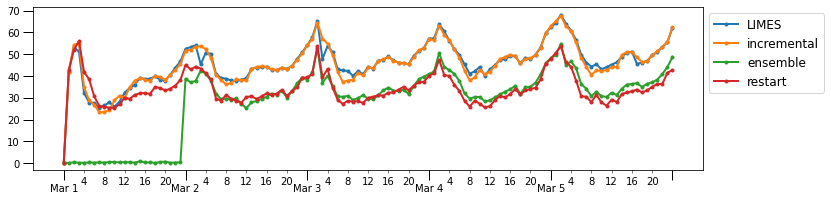

In [8]:
import matplotlib.ticker as ticker

def plot_curve(ax, method, features='tweet', subset='0_5'):
    res = 100*RES[features,subset,method][0]
    ax.plot(range(start,end),res[start:end],label=method, linewidth=2, marker='.')

start,end = 0,5*24+1
fig = plt.figure(figsize=(12,3))


ax = plt.gca()
ax.tick_params(which='major', width=1.00, length=10, labelsize=10)
ax.tick_params(which='minor', width=0.5, length=2.5, labelsize=10)
# Fixed formatter
ax.xaxis.set_major_locator(ticker.MultipleLocator(24.0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))

xvals = list(range(start,end))

majors = [f"Mar {d//24}" for d in xvals[::24]]
ax.set_xticks(xvals[::4], minor=True)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(majors))
minors = [f"{d%24}" for d in xvals[::4] if d%24 != 0]
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(minors))

plot_curve(ax, method="LIMES")
plot_curve(ax, method="incremental")
plot_curve(ax, method="ensemble")
plot_curve(ax, method="restart")

ax.legend(bbox_to_anchor=(1.0, 1.0),fontsize=12)

plt.savefig("accuracy-plot-tweet-0_5.pdf", bbox_inches='tight', pad_inches=0, facecolor='none', edgecolor='none')

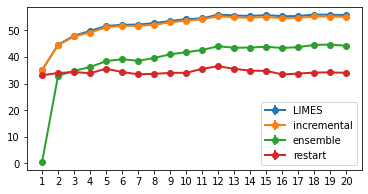

In [9]:
def plot_aggregate_curve(methods, features='tweet', subset='0_5', op='avg'):
    DATASOURCE = {'avg':AVG_ACC, 'min':MIN_ACC}
    
    for method in methods:
        res = 100*RES[(features,subset,method)].reshape(10,-1,24)
        if op == 'avg':
            res = res.mean(axis=-1)
        elif op == 'min':
            res = res.min(axis=-1)
        else:
            print("Unknown operation")
            return
        m,s = res.mean(axis=0),res.std(axis=0)
        plt.errorbar(x=range(1,len(m)+1),y=m,yerr=s,label=method, marker='o', linewidth=2)

fig=plt.figure(figsize=(6,3))
plot_aggregate_curve(methods=["LIMES", "incremental", "ensemble", "restart"])
end = int(np.ceil(fig.axes[0].get_xlim()[1]))
plt.xticks(range(1,int(np.ceil(end))))
plt.legend()

plt.savefig("accuracy_avg-plot-tweet-0_5.pdf", bbox_inches='tight', pad_inches=0, facecolor='none', edgecolor='none')

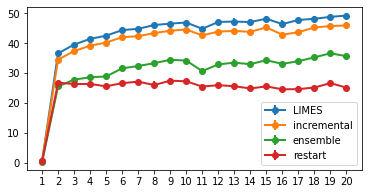

In [9]:
fig=plt.figure(figsize=(6,3))
plot_aggregate_curve(methods=["LIMES", "incremental", "ensemble", "restart"], op='min')
end = int(np.ceil(fig.axes[0].get_xlim()[1]))
plt.xticks(range(1,int(np.ceil(end))))
plt.legend()
plt.savefig("accuracy_min-plot-tweet-0_5.pdf", bbox_inches='tight', pad_inches=0, facecolor='none', edgecolor='none')

## Frequency of countries

In [10]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [11]:
F = sorted(glob.glob('geo-2020_03_0[1]_??-countries.txt'))
df=[pd.read_csv(f,header=None,delim_whitespace=True,names=["count","country"],index_col="country",na_values=[""],keep_default_na=False) for f in F]
df=[data/data.sum() for data in df]
G=[f.split('-')[1] for f in F]
df = pd.concat(df,axis=1, keys=G)
df['total'] = df.sum(axis=1)
top10 = df.nlargest(10,'total')
del top10['total']

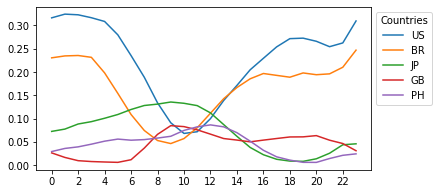

In [12]:
fig = plt.figure(figsize=(6,3))
for country in top10.index[:5]:
    row = top10.loc[country]
    x = range(len(row.index))
    ##print(row.head())
    sns.lineplot(x=x, y=row.values,label=country)
    # print(row.index)
    
sns.move_legend(fig.get_axes()[0], "upper left", bbox_to_anchor=(1, 1), title='Countries')
plt.xticks(range(0,24,2))
plt.savefig('country-distribution-2020-03-01.pdf', bbox_inches='tight', pad_inches=0)